In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 100,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.8827160493827161, Loss: 0.519218020968967
Checkpoint 20, Accuracy: 0.9135802469135802, Loss: 0.46259565706606265
Checkpoint 30, Accuracy: 0.9197530864197531, Loss: 0.43697350113480177
Checkpoint 40, Accuracy: 0.9135802469135802, Loss: 0.41973053967511215
Checkpoint 50, Accuracy: 0.9382716049382716, Loss: 0.379309406986943
Checkpoint 60, Accuracy: 0.9567901234567902, Loss: 0.3761798010932075
Checkpoint 70, Accuracy: 0.9444444444444444, Loss: 0.3214284755565502
Checkpoint 80, Accuracy: 0.9506172839506173, Loss: 0.2938074359187373
Checkpoint 90, Accuracy: 0.9444444444444444, Loss: 0.2714451683892144
Checkpoint 100, Accuracy: 0.9629629629629629, Loss: 0.22577631915057148
Checkpoint 110, Accuracy: 0.9629629629629629, Loss: 0.20212664427580657
Checkpoint 120, Accuracy: 0.9629629629629629, Loss: 0.15246124620790835
Checkpoint 130, Accuracy: 0.9814814814814815, Loss: 0.13275798161824545
Checkpoint 140, Accuracy: 0.9753086419753086, Loss: 0.12741219555890118
Checkpoin

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.852781   0.00709663 0.14012235]
[1. 0. 0.] <-> [0.9783589  0.00438359 0.01725741]
[1. 0. 0.] <-> [0.99306786 0.00297832 0.00395387]
[1. 0. 0.] <-> [0.98645705 0.00281011 0.01073281]
[0. 0. 1.] <-> [0.00855967 0.00109174 0.9903486 ]
[1. 0. 0.] <-> [0.84659356 0.09717832 0.05622811]
[1. 0. 0.] <-> [0.995723   0.00199711 0.00227984]
[0. 0. 1.] <-> [0.09834322 0.00466452 0.89699227]
[1. 0. 0.] <-> [0.5100301  0.47518045 0.0147895 ]
[1. 0. 0.] <-> [0.9936918  0.00196483 0.00434331]
[1. 0. 0.] <-> [0.99206877 0.00218503 0.0057462 ]
[1. 0. 0.] <-> [0.99671125 0.0013703  0.00191848]
[1. 0. 0.] <-> [0.99672204 0.00140138 0.00187665]
[1. 0. 0.] <-> [0.9905155  0.00574963 0.00373493]
[1. 0. 0.] <-> [0.99397814 0.00340974 0.00261209]
[0. 0. 1.] <-> [0.01312212 0.00172198 0.9851559 ]
[1. 0. 0.] <-> [0.24414031 0.7450209  0.01083881]
[1. 0. 0.] <-> [0.8750531  0.1137369  0.01121004]
[1. 0. 0.] <-> [0.9959661  0.00158035 0.00245347]
[1. 0. 0.] <-> [0.995394   0.00281845 0.00178761]


In [11]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

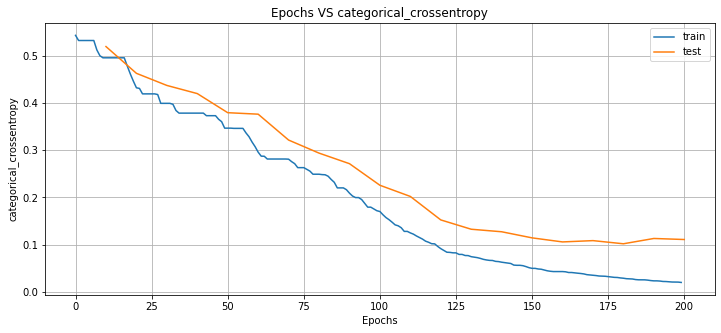

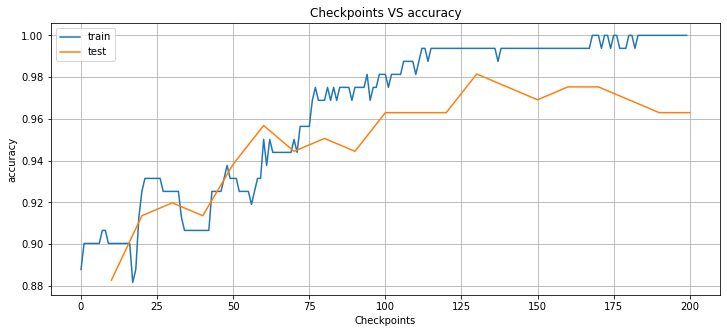

In [12]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8827160493827161, 'mean_square_error': 0.2779918122252924, 'categorical_crossentropy': 0.519218020968967, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 14, 'tn_hit': 16, 'fn_hit': 3}, 1: {'tp_hit': 5, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 11}, 2: {'tp_hit': 9, 'fp_hit': 5, 'tn_hit': 89, 'fn_hit': 5}}, 'checkpoint': 10} 


{'accuracy': 0.9135802469135802, 'mean_square_error': 0.2411975783870395, 'categorical_crossentropy': 0.46259565706606265, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 11, 'tn_hit': 19, 'fn_hit': 1}, 1: {'tp_hit': 8, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 8}, 2: {'tp_hit': 9, 'fp_hit': 3, 'tn_hit': 91, 'fn_hit': 5}}, 'checkpoint': 20} 


{'accuracy': 0.9197530864197531, 'mean_square_error': 0.20194077620881704, 'categorical_crossentropy': 0.43697350113480177, 'essential_metrics': {0: {'tp_hit': 73, 'fp_hit': 6, 'tn_hit': 24, 'fn_hit': 5}, 1: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 9, 'fp_hit': 6, 'tn_hit': 88, 'fn_hit

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.3141861   3.         -0.97271174 -3.         -2.6810906 ]
 bias: 1.6154627799987793

Neuron 1: weights:
[-2.3258529  3.         3.        -1.1004814  0.7345121]
 bias: -2.3050825595855713

Neuron 2: weights:
[ 0.11426107 -3.         -1.3063369   2.027808    2.8204484 ]
 bias: -2.758906126022339

Neuron 3: weights:
[-1.8236796  3.         1.9926381  0.6186596  1.0263848]
 bias: -1.5613776445388794

$
Layer 2
Neuron 0: weights:
[ 3.        -3.        -2.5997021 -3.       ]
 bias: 1.818196177482605

Neuron 1: weights:
[0.89799094 3.         0.15943082 3.        ]
 bias: -3.0

Neuron 2: weights:
[-3.         0.7165296  3.        -1.4598498]
 bias: 0.9729900360107422

$

